In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List, Iterable

# Определение GridWorld

UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
ACTIONS = [UP, RIGHT, DOWN, LEFT]
ACTION_ARROWS = {
    UP:    '^',
    RIGHT: '>',
    DOWN:  'v',
    LEFT:  '<'
}

@dataclass
class GridWorld:
    width: int
    height: int
    walls: set
    terminal_rewards: Dict[Tuple[int, int], float]
    step_reward: float = -1.0

    def __post_init__(self):
        self.states: List[int] = []
        self.state_to_pos: Dict[int, Tuple[int, int]] = {}
        self.pos_to_state: Dict[Tuple[int, int], int] = {}

        s = 0
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) in self.walls:
                    continue
                self.state_to_pos[s] = (x, y)
                self.pos_to_state[(x, y)] = s
                self.states.append(s)
                s += 1

        self.n_states = len(self.states)
        self.n_actions = len(ACTIONS)

        # терминальные состояния (по позициям из terminal_rewards)
        self.terminal_states = set()
        for pos in self.terminal_rewards:
            if pos in self.pos_to_state:
                self.terminal_states.add(self.pos_to_state[pos])

def move(gw: GridWorld, x: int, y: int, a: int):
    """
    Детерминированное действие.
    Возвращает: (x2, y2), reward, done
    """
    if (x, y) in gw.terminal_rewards:
        return (x, y), 0.0, True

    if a == UP:
        x2, y2 = x, max(0, y - 1)
    elif a == DOWN:
        x2, y2 = x, min(gw.height - 1, y + 1)
    elif a == LEFT:
        x2, y2 = max(0, x - 1), y
    elif a == RIGHT:
        x2, y2 = min(gw.width - 1, x + 1), y
    else:
        raise ValueError("unknown action")

    if (x2, y2) in gw.walls:
        x2, y2 = x, y

    pos2 = (x2, y2)
    if pos2 in gw.terminal_rewards:
        r = gw.terminal_rewards[pos2]
        done = True
    else:
        r = gw.step_reward
        done = False
    return pos2, r, done

def build_transition_model(gw: GridWorld):
    """
    Строит табличную модель:
    P[s][a] = список (p, s_next, reward, done)
    """
    P = [[[] for _ in ACTIONS] for _ in range(gw.n_states)]
    for s in gw.states:
        x, y = gw.state_to_pos[s]
        for a in ACTIONS:
            pos2, r, done = move(gw, x, y, a)
            s2 = gw.pos_to_state[pos2]
            P[s][a].append((1.0, s2, r, done))
    return P

In [ ]:
# Policy Evaluation

def policy_evaluation(P, policy, gamma=0.99, theta=1e-4,
                      in_place=False, max_iters=10_000):
    """
    V_{k+1}(s) = sum_a pi(a|s) sum_{s'} P(s'|s,a)[R + gamma * V_k(s')]
    Здесь pi детерминирована: policy[s] -> action.
    """
    n_states = len(P)
    V = np.zeros(n_states)
    sweeps = 0

    while sweeps < max_iters:
        delta = 0.0

        if in_place:   # Gauss–Seidel
            for s in range(n_states):
                a = policy[s]
                v_old = V[s]
                v_new = 0.0
                for (p, s2, r, done) in P[s][a]:
                    v_new += p * (r + gamma * (0.0 if done else V[s2]))
                V[s] = v_new
                delta = max(delta, abs(v_new - v_old))
        else:          # synchronous
            V_new = np.zeros_like(V)
            for s in range(n_states):
                a = policy[s]
                v_new = 0.0
                for (p, s2, r, done) in P[s][a]:
                    v_new += p * (r + gamma * (0.0 if done else V[s2]))
                V_new[s] = v_new
                delta = max(delta, abs(v_new - V[s]))
            V = V_new

        sweeps += 1
        if delta < theta:
            break

    return V, sweeps

In [ ]:
# Policy Improvement / Iteration


def greedy_policy_from_V(P, V, gamma=0.99):
    n_states = len(P)
    n_actions = len(P[0])
    policy = np.zeros(n_states, dtype=int)

    for s in range(n_states):
        q_vals = np.empty(n_actions)
        for a in range(n_actions):
            q_sa = 0.0
            for (p, s2, r, done) in P[s][a]:
                q_sa += p * (r + gamma * (0.0 if done else V[s2]))
            q_vals[a] = q_sa
        policy[s] = int(np.argmax(q_vals))
    return policy

def policy_iteration(P, gamma=0.99, theta_eval=1e-4,
                     in_place_eval=False, max_eval_iters=1_000):
    """
    Классический Policy Iteration:
    - полная оценка политики до сходимости (по порогу θ)
    - шаг улучшения (greedy policy w.r.t. V^π)
    """
    n_states = len(P)
    policy = np.random.randint(0, len(P[0]), size=n_states)

    stable = False
    n_improvements = 0
    total_eval_sweeps = 0

    while not stable:
        # Policy Evaluation
        V, sweeps = policy_evaluation(
            P, policy, gamma=gamma, theta=theta_eval,
            in_place=in_place_eval, max_iters=max_eval_iters
        )
        total_eval_sweeps += sweeps

        # Policy Improvement
        stable = True
        for s in range(n_states):
            old_a = policy[s]
            best_a = old_a
            best_q = -1e18
            for a in range(len(P[0])):
                q_sa = 0.0
                for (p, s2, r, done) in P[s][a]:
                    q_sa += p * (r + gamma * (0.0 if done else V[s2]))
                if q_sa > best_q:
                    best_q = q_sa
                    best_a = a
            policy[s] = best_a
            if best_a != old_a:
                stable = False

        n_improvements += 1
        if n_improvements > 1_000:   # защита от зацикливания
            break

    return policy, V, n_improvements, total_eval_sweeps

In [ ]:
# Modified Policy Iteration (дополнительно)

def modified_policy_iteration(P, gamma=0.99, theta_eval=1e-4, m=3,
                              in_place_eval=False, max_iters=1_000):
    """
    MPI: вместо точной оценки делаем m итераций оценивания
    перед каждым шагом улучшения.
    """
    n_states = len(P)
    policy = np.random.randint(0, len(P[0]), size=n_states)
    V = np.zeros(n_states)

    stable = False
    n_improvements = 0
    total_sweeps = 0

    while not stable and n_improvements < max_iters:
        # m итераций оценивания, начиная с текущего V
        for k in range(m):
            delta = 0.0
            if in_place_eval:
                for s in range(n_states):
                    v_old = V[s]
                    a = policy[s]
                    v_new = 0.0
                    for (p, s2, r, done) in P[s][a]:
                        v_new += p * (r + gamma * (0.0 if done else V[s2]))
                    V[s] = v_new
                    delta = max(delta, abs(v_new - v_old))
            else:
                V_new = np.zeros_like(V)
                for s in range(n_states):
                    a = policy[s]
                    v_new = 0.0
                    for (p, s2, r, done) in P[s][a]:
                        v_new += p * (r + gamma * (0.0 if done else V[s2]))
                    V_new[s] = v_new
                    delta = max(delta, abs(v_new - V[s]))
                V = V_new
            total_sweeps += 1
            if delta < theta_eval:
                break

        # шаг улучшения
        stable = True
        for s in range(n_states):
            old_a = policy[s]
            best_a = old_a
            best_q = -1e18
            for a in range(len(P[0])):
                q_sa = 0.0
                for (p, s2, r, done) in P[s][a]:
                    q_sa += p * (r + gamma * (0.0 if done else V[s2]))
                if q_sa > best_q:
                    best_q = q_sa
                    best_a = a
            policy[s] = best_a
            if best_a != old_a:
                stable = False

        n_improvements += 1

    return policy, V, n_improvements, total_sweeps

In [ ]:
# Value Iteration

def value_iteration(P, gamma=0.99, theta=1e-4,
                    in_place=True, max_iters=10_000):
    """
    V_{k+1}(s) = max_a sum_{s'} P(s'|s,a)[R + gamma * V_k(s')]
    Используем порог на остаток Δ.
    Для гарантии ε-оптимальности можно брать
    Δ < θ * (1 - γ) / (2γ) как в лекции.
    """
    n_states = len(P)
    V = np.zeros(n_states)
    sweeps = 0

    # строгий критерий из лекции
    thresh = theta * (1 - gamma) / (2 * gamma) if gamma != 0 else theta

    while sweeps < max_iters:
        delta = 0.0

        if in_place:
            for s in range(n_states):
                v_old = V[s]
                best_q = -1e18
                for a in range(len(P[0])):
                    q_sa = 0.0
                    for (p, s2, r, done) in P[s][a]:
                        q_sa += p * (r + gamma * (0.0 if done else V[s2]))
                    if q_sa > best_q:
                        best_q = q_sa
                V[s] = best_q
                delta = max(delta, abs(best_q - v_old))
        else:
            V_new = np.zeros_like(V)
            for s in range(n_states):
                best_q = -1e18
                for a in range(len(P[0])):
                    q_sa = 0.0
                    for (p, s2, r, done) in P[s][a]:
                        q_sa += p * (r + gamma * (0.0 if done else V[s2]))
                    if q_sa > best_q:
                        best_q = q_sa
                V_new[s] = best_q
                delta = max(delta, abs(best_q - V[s]))
            V = V_new

        sweeps += 1
        if delta < thresh:
            break

    policy = greedy_policy_from_V(P, V, gamma)
    return policy, V, sweeps

In [ ]:
# Визуализация (V и политика)


def value_to_grid(gw: GridWorld, V: np.ndarray):
    """
    Перевод в матрицу HxW, в стенки кладём NaN для красоты.
    """
    grid = np.full((gw.height, gw.width), np.nan)
    for s in gw.states:
        x, y = gw.state_to_pos[s]
        grid[y, x] = V[s]
    return grid

def policy_to_grid(gw: GridWorld, policy: np.ndarray):
    arrows = np.full((gw.height, gw.width), ' ', dtype='<U1')
    for s in gw.states:
        x, y = gw.state_to_pos[s]
        if s in gw.terminal_states:
            arrows[y, x] = 'T'
        else:
            arrows[y, x] = ACTION_ARROWS[policy[s]]
    for (x, y) in gw.walls:
        arrows[y, x] = '#'
    return arrows

def plot_value_and_policy(gw: GridWorld, V: np.ndarray, policy: np.ndarray,
                          title_prefix: str = ""):
    grid_V = value_to_grid(gw, V)
    grid_pi = policy_to_grid(gw, policy)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(grid_V, origin='upper')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    for y in range(gw.height):
        for x in range(gw.width):
            ax.text(x, y, grid_pi[y, x],
                    ha='center', va='center', fontsize=14, color='k')
    ax.set_xticks(range(gw.width))
    ax.set_yticks(range(gw.height))
    ax.set_title(f"{title_prefix}Value function and policy")
    plt.show()

In [ ]:
 # Пример мира (>=5x5 с ямой, стенами и целью)

walls = {(1, 1), (3, 1), (1, 3)}
terminal_rewards = {
    (4, 4): 10.0,
    (2, 2): -10.0
}

gw = GridWorld(
    width=5,
    height=5,
    walls=walls,
    terminal_rewards=terminal_rewards,
    step_reward=-1.0
)

P = build_transition_model(gw)

start_state = gw.pos_to_state[(0, 0)]

print("Количество состояний (без стен):", gw.n_states)
print("Количество действий:", gw.n_actions)

Количество состояний (без стен): 22
Количество действий: 4


In [ ]:
gammas = [0.8, 0.9, 0.99]
thetas = [1e-2, 1e-4]

results = []

for gamma in gammas:
    for theta in thetas:
        # Policy Iteration (синхронная оценка)
        pi_policy, pi_V, pi_impr, pi_sweeps = policy_iteration(
            P, gamma=gamma, theta_eval=theta,
            in_place_eval=False
        )

        # Value Iteration (in-place)
        vi_policy, vi_V, vi_sweeps = value_iteration(
            P, gamma=gamma, theta=theta,
            in_place=True
        )

        res = {
            "gamma": gamma,
            "theta": theta,
            "PI_eval_sweeps": pi_sweeps,
            "PI_improvements": pi_impr,
            "VI_sweeps": vi_sweeps,
            "V_start_PI": pi_V[start_state],
            "V_start_VI": vi_V[start_state]
        }
        results.append(res)

        print("gamma = %.2f, theta = %.1e" % (gamma, theta))
        print("  Policy Iteration:  sweeps_eval = %d, improvements = %d, V(start) = %.3f"
              % (pi_sweeps, pi_impr, pi_V[start_state]))
        print("  Value  Iteration: sweeps = %d, V(start) = %.3f"
              % (vi_sweeps, vi_V[start_state]))
        print()

gamma = 0.80, theta = 1.0e-02
  Policy Iteration:  sweeps_eval = 172, improvements = 9, V(start) = -1.854
  Value  Iteration: sweeps = 9, V(start) = -1.854

gamma = 0.80, theta = 1.0e-04
  Policy Iteration:  sweeps_eval = 353, improvements = 9, V(start) = -1.854
  Value  Iteration: sweeps = 9, V(start) = -1.854

gamma = 0.90, theta = 1.0e-02
  Policy Iteration:  sweeps_eval = 369, improvements = 9, V(start) = -0.434
  Value  Iteration: sweeps = 9, V(start) = -0.434

gamma = 0.90, theta = 1.0e-04
  Policy Iteration:  sweeps_eval = 552, improvements = 8, V(start) = -0.434
  Value  Iteration: sweeps = 9, V(start) = -0.434

gamma = 0.99, theta = 1.0e-02
  Policy Iteration:  sweeps_eval = 1885, improvements = 9, V(start) = 2.527
  Value  Iteration: sweeps = 9, V(start) = 2.527

gamma = 0.99, theta = 1.0e-04
  Policy Iteration:  sweeps_eval = 3704, improvements = 8, V(start) = 2.527
  Value  Iteration: sweeps = 9, V(start) = 2.527



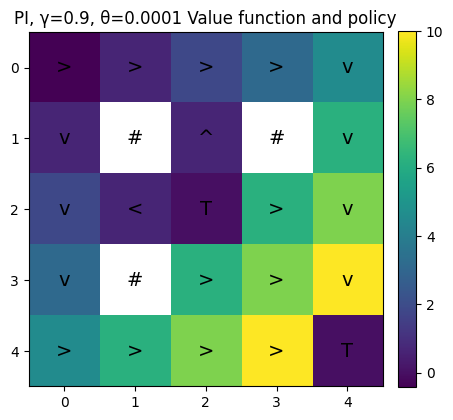

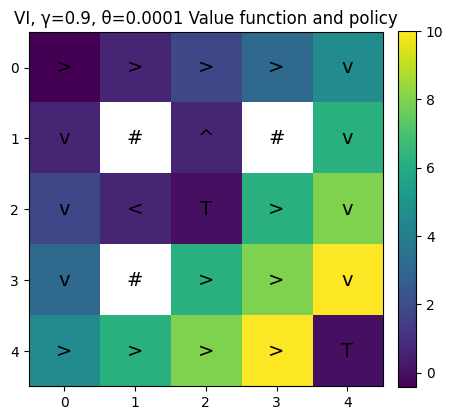

Modified PI (m=1): improvements=8, sweeps=8
Modified PI (m=3): improvements=9, sweeps=24
Modified PI (m=5): improvements=9, sweeps=35


In [ ]:
gamma = 0.9
theta = 1e-4

pi_policy, pi_V, _, _ = policy_iteration(P, gamma=gamma, theta_eval=theta)
vi_policy, vi_V, _ = value_iteration(P, gamma=gamma, theta=theta)

plot_value_and_policy(gw, pi_V, pi_policy,
                      title_prefix=f"PI, γ={gamma}, θ={theta} ")
plot_value_and_policy(gw, vi_V, vi_policy,
                      title_prefix=f"VI, γ={gamma}, θ={theta} ")


for m in [1, 3, 5]:
    mpi_policy, mpi_V, mpi_impr, mpi_sweeps = modified_policy_iteration(
        P, gamma=0.9, theta_eval=1e-4, m=m, in_place_eval=True
    )
    print(f"Modified PI (m={m}): improvements={mpi_impr}, sweeps={mpi_sweeps}")

В ходе работы я реализовал три основных алгоритма динамического программирования для GridWorld: Policy Iteration (PI), Value Iteration (VI) и Modified Policy Iteration (MPI), а также протестировал их поведение при разных значениях γ ∈ {0.8, 0.9, 0.99} и θ ∈ {10⁻², 10⁻⁴}.

1. Сравнение Policy Iteration и Value Iteration

По итогам экспериментов оба алгоритма сходятся к одинаковой оптимальной политике и фактически одинаковому оптимальному значению V(start).
Однако:

Value Iteration стабильно сходится быстрее (около 9 sweeps во всех конфигурациях),

Policy Iteration требует намного больше итераций оценки политики - особенно при больших γ и малых θ.
Например, для γ = 0.99 и θ = 10⁻⁴ потребовалось 3704 прохода, тогда как у VI - те же 9.

То есть VI более устойчив по числу итераций и не так чувствителен к параметрам сходимости.

2. Влияние γ (discount factor)

Увеличение γ делает будущее более важным. Это приводит к:

росту значений V(s), особенно ближе к цели,

замедлению сходимости PI, так как ошибка "передаётся" дальше по времени,

VI остаётся относительно стабильным, но значение V(start) увеличивается при переходе от γ=0.8 к γ=0.99.

3. Влияние θ (порог сходимости)

Маленький θ (10⁻⁴) заставляет алгоритмы работать дольше, так как требуется более точная оценка.

Особенно сильно это влияет на Policy Iteration, которому приходится много раз обновлять значения V(s).

Value Iteration почти не меняет число sweeps - он более гибкий и быстрее достигает нужной точности.

4. Тепловые карты и политики

Значения V(s) логично возрастали по направлению к цели и снижались возле ямы.
Стрелки политики показывают, что оптимальная стратегия ведёт агента:

обходить стены и яму,

максимально быстро двигаться к цели.

Политики PI и VI полностью совпадают визуально.

5. Modified Policy Iteration

MPI показал ожидаемое поведение:

при m=1 сходится быстрее по числу sweeps,

при больших m даёт чуть более точные оценки, но требует больше итераций.

MPI оказался промежуточным вариантом между PI (самый дорогой) и VI (самый быстрый в нашей постановке).